# Description

It loads the correlation values and p-values and perform some analyses and plots.

# Modules

In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns

from ccc import conf

# Settings

In [2]:
# this gene pair was originally found with ccc on whole blood
# interesting: https://clincancerres.aacrjournals.org/content/26/21/5567.figures-only
gene0_id, gene1_id = "ENSG00000147050.14", "ENSG00000067048.16"
gene0_symbol, gene1_symbol = "KDM6A", "DDX3Y"

# Paths

In [3]:
TISSUE_DIR = conf.GTEX["DATA_DIR"] / "data_by_tissue"
assert TISSUE_DIR.exists()

In [4]:
INPUT_DIR = (
    conf.GTEX["RESULTS_DIR"]
    / "other_tissues"
    / f"{gene0_symbol.lower()}_vs_{gene1_symbol.lower()}"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gtex_v8/other_tissues/kdm6a_vs_ddx3y')

In [5]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"]
    / "coefs_comp"
    / f"{gene0_symbol.lower()}_vs_{gene1_symbol.lower()}"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y')

# Data

## GTEx metadata

In [6]:
gtex_metadata = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_v8-sample_metadata.pkl")

In [7]:
gtex_metadata.shape

(22951, 66)

In [8]:
gtex_metadata.head()

,SUBJID,SEX,AGE,DTHHRDY,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gene Ensembl ID -> Symbol mapping

In [9]:
gene_map = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_gene_id_symbol_mappings.pkl")

In [10]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [11]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

In [12]:
assert gene_map[gene0_id] == gene0_symbol
assert gene_map[gene1_id] == gene1_symbol

## Correlation on all tissues

In [13]:
res_all = pd.read_pickle(INPUT_DIR / "coef_values.pkl")

In [14]:
res_all.shape

(50, 3)

In [15]:
res_all.head()

,cm,pearson,spearman
colon_transverse,0.280814,0.393881,0.465898
brain_amygdala,0.305677,0.038732,0.154331
artery_coronary,0.242720,0.487610,0.426164
artery_aorta,0.381970,0.579236,0.409761
adrenal_gland,0.188929,0.489400,0.418784


## P-values on all tissues

In [16]:
res_pval_all = pd.read_pickle(INPUT_DIR / "coef_pvalues.pkl")

In [17]:
res_pval_all.shape

(50, 3)

In [18]:
res_pval_all.head()

,cm,pearson,spearman
colon_transverse,9.999990e-07,1.613504e-16,2.880714e-23
brain_amygdala,9.999990e-07,6.356755e-01,5.764275e-02
artery_coronary,9.999990e-07,9.731623e-16,5.220895e-12
artery_aorta,9.999990e-07,4.513966e-40,6.380372e-19
adrenal_gland,9.999990e-07,6.058615e-17,2.230048e-12


In [19]:
-np.log10(res_pval_all).describe()

,cm,pearson,spearman
count,-50.000000,-50.000000,-50.000000
mean,5.423408,14.951580,9.041762
std,-1.716959,-18.994241,-9.912384
min,6.000000,74.216535,48.436254
25%,6.000000,21.264361,14.649422
50%,6.000000,8.485474,4.985711
75%,6.000000,1.174125,1.977859
max,0.201847,0.132734,0.229321


### Adjust p-values

In [20]:
for col in ("cm", "pearson", "spearman"):
    adj_pvals = multipletests(res_pval_all[col], alpha=0.05, method="fdr_bh")
    res_pval_all = res_pval_all.assign(**{col: adj_pvals[1]})

In [21]:
res_pval_all.shape

(50, 3)

In [22]:
res_pval_all.head()

,cm,pearson,spearman
colon_transverse,0.000001,4.745601e-16,2.400595e-22
brain_amygdala,0.000001,6.592677e-01,7.151064e-02
artery_coronary,0.000001,2.703229e-15,1.740298e-11
artery_aorta,0.000001,4.513966e-39,3.544651e-18
adrenal_gland,0.000001,1.893317e-16,7.964457e-12


In [23]:
-np.log10(res_pval_all).describe()

,cm,pearson,spearman
count,-50.000000,-50.000000,-50.000000
mean,5.371846,14.542516,8.632825
std,-1.705506,-18.615988,-9.530766
min,5.944483,72.517564,46.737284
25%,5.944483,20.687380,14.072441
50%,5.944483,8.192960,4.693198
75%,5.944483,1.052043,1.855777
max,0.201847,0.132734,0.229321


# Plot

In [24]:
def get_tissue_file(name):
    """
    Given a part of a tissue name, it returns a file path to the
    expression data for that tissue in GTEx. It fails if more than
    one files are found.

    Args:
        name: a string with the tissue name (or a part of it).

    Returns:
        A Path object pointing to the gene expression file for the
        given tissue.
    """
    tissue_files = []
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            tissue_files.append(f)

    assert len(tissue_files) == 1
    return tissue_files[0]

In [25]:
# testing
_tmp = get_tissue_file("whole_blood")
assert _tmp.exists()

In [26]:
def simplify_tissue_name(tissue_name):
    return f"{tissue_name[0].upper()}{tissue_name[1:].replace('_', ' ')}"

In [27]:
assert simplify_tissue_name("whole_blood") == "Whole blood"
assert simplify_tissue_name("uterus") == "Uterus"

In [28]:
def pvalue_to_star(pvalue):
    s = ""
    if pvalue < 0.001:
        s = "***"
    elif pvalue < 0.01:
        s = "**"
    elif pvalue < 0.05:
        s = "*"

    return s

In [29]:
def plot_gene_pair(
    tissue_name, gene0, gene1, hue=None, kind="hex", ylim=None, bins="log"
):
    """
    It plots (joint plot) a gene pair from the given tissue. It saves the plot
    for the manuscript.
    """
    # merge gene expression with metadata
    tissue_file = get_tissue_file(tissue_name)
    tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]
    tissue_data = pd.merge(
        tissue_data,
        gtex_metadata,
        how="inner",
        left_index=True,
        right_index=True,
        validate="one_to_one",
    )

    # get gene symbols
    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # compute correlations for this gene pair
    tissue_key = tissue_file.stem.split("_data_")[1]

    _ccc = res_all.loc[tissue_key, "cm"]
    _ccc_p = pvalue_to_star(res_pval_all.loc[tissue_key, "cm"])
    _pearson = res_all.loc[tissue_key, "pearson"]
    _pearson_p = pvalue_to_star(res_pval_all.loc[tissue_key, "pearson"])
    _spearman = res_all.loc[tissue_key, "spearman"]
    _spearman_p = pvalue_to_star(res_pval_all.loc[tissue_key, "spearman"])

    _title = f"{simplify_tissue_name(tissue_name)}\n$c={_ccc:.2f}${_ccc_p}  $p={_pearson:.2f}${_pearson_p}  $s={_spearman:.2f}${_spearman_p}"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
        "rasterized": True,
    }
    if hue is None:
        other_args["bins"] = bins
    else:
        other_args["hue_order"] = ["Male", "Female"]

    with sns.plotting_context("paper", font_scale=1.5):
        p = sns.jointplot(
            data=tissue_data,
            x=gene0,
            y=gene1,
            hue=hue,
            **other_args,
            # ylim=(0, 500),
        )

        if ylim is not None:
            p.ax_joint.set_ylim(ylim)

        gene_x_id = p.ax_joint.get_xlabel()
        gene_x_symbol = gene_map[gene_x_id]
        p.ax_joint.set_xlabel(f"{gene_x_symbol}", fontstyle="italic")

        gene_y_id = p.ax_joint.get_ylabel()
        gene_y_symbol = gene_map[gene_y_id]
        p.ax_joint.set_ylabel(f"{gene_y_symbol}", fontstyle="italic")

        p.fig.suptitle(_title)

        # save
        output_file = (
            OUTPUT_FIGURE_DIR
            / f"gtex_{tissue_name}-{gene_x_symbol}_vs_{gene_y_symbol}.svg"
        )
        display(output_file)

        plt.savefig(
            output_file,
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
        )

    return tissue_data

## In whole blood (where this gene pair was found)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_whole_blood-KDM6A_vs_DDX3Y.svg')

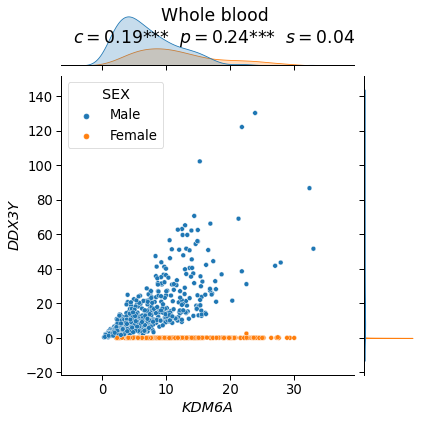

In [30]:
_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Lowest tissues in ccc

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_uterus-KDM6A_vs_DDX3Y.svg')

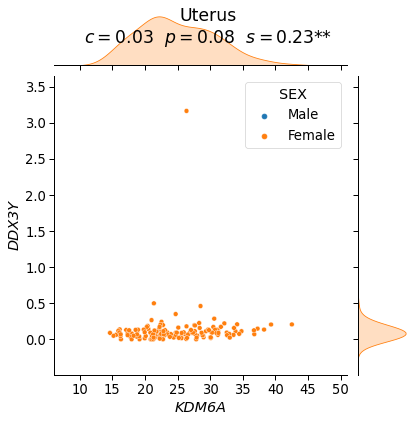

In [31]:
_tissue_data = plot_gene_pair(
    "uterus",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_ovary-KDM6A_vs_DDX3Y.svg')

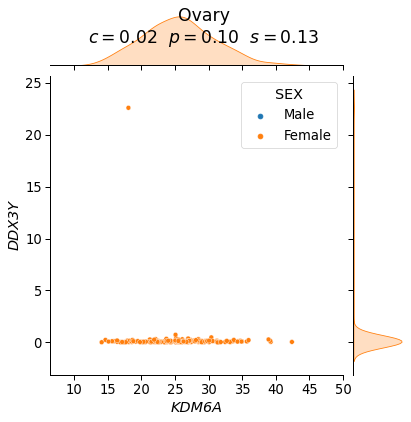

In [32]:
_tissue_data = plot_gene_pair(
    "ovary",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_vagina-KDM6A_vs_DDX3Y.svg')

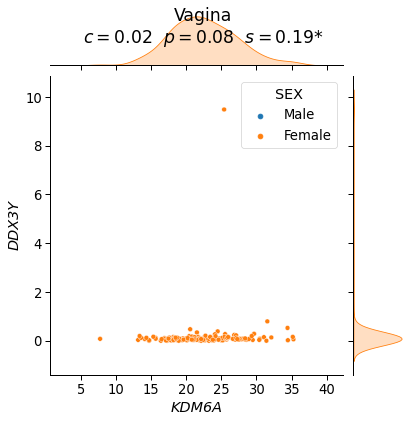

In [33]:
_tissue_data = plot_gene_pair(
    "vagina",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_brain_cerebellum-KDM6A_vs_DDX3Y.svg')

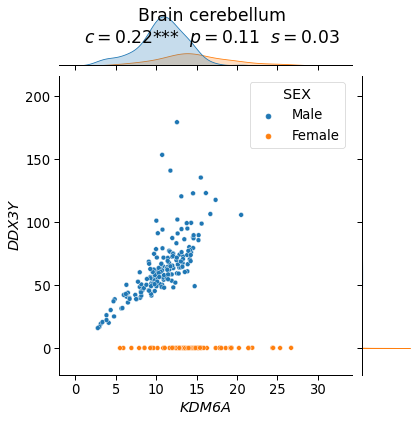

In [34]:
_tissue_data = plot_gene_pair(
    "brain_cerebellum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_small_intestine_terminal_ileum-KDM6A_vs_DDX3Y.svg')

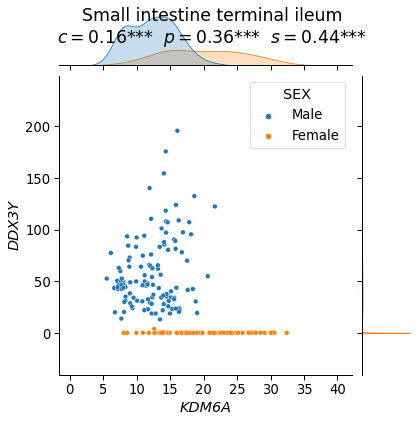

In [35]:
_tissue_data = plot_gene_pair(
    "small_intestine_terminal_ileum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_brain_spinal_cord_cervical_c1-KDM6A_vs_DDX3Y.svg')

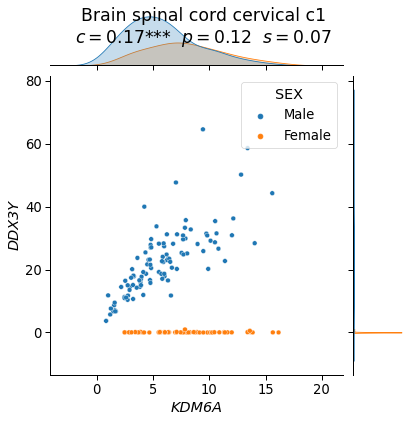

In [36]:
_tissue_data = plot_gene_pair(
    "brain_spinal_cord_cervical_c1",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_testis-KDM6A_vs_DDX3Y.svg')

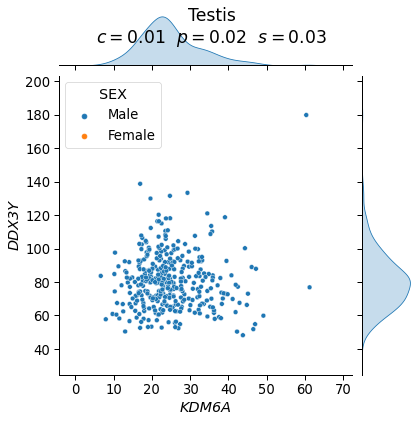

In [37]:
_tissue_data = plot_gene_pair(
    "testis",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Highest tissues in ccc

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_cells_cultured_fibroblasts-KDM6A_vs_DDX3Y.svg')

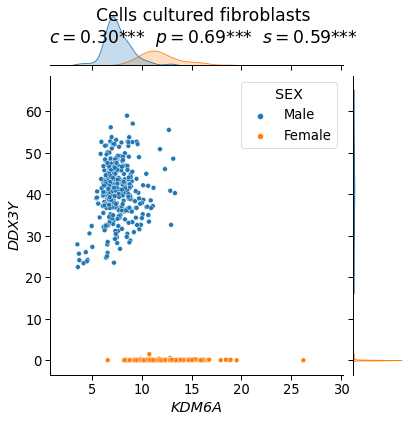

In [38]:
_tissue_data = plot_gene_pair(
    "cells_cultured_fibroblasts",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_breast_mammary_tissue-KDM6A_vs_DDX3Y.svg')

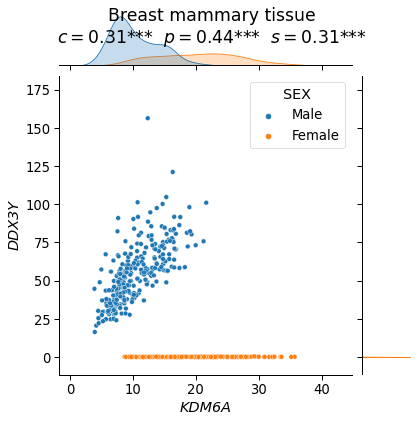

In [39]:
_tissue_data = plot_gene_pair(
    "breast_mammary_tissue",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Pearson low, CCC high

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_brain_anterior_cingulate_cortex_ba24-KDM6A_vs_DDX3Y.svg')

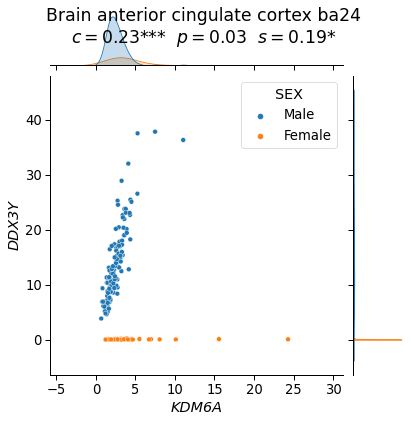

In [40]:
_tissue_data = plot_gene_pair(
    "brain_anterior_cingulate_cortex_ba24",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_brain_amygdala-KDM6A_vs_DDX3Y.svg')

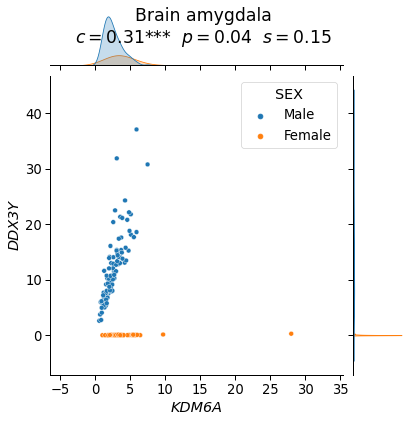

In [41]:
_tissue_data = plot_gene_pair(
    "brain_amygdala",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_brain_frontal_cortex_ba9-KDM6A_vs_DDX3Y.svg')

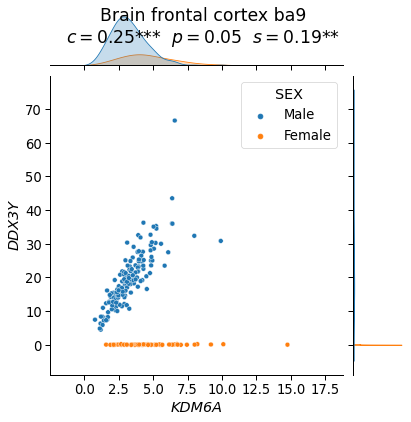

In [42]:
_tissue_data = plot_gene_pair(
    "brain_frontal_cortex_ba9",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_bladder-KDM6A_vs_DDX3Y.svg')

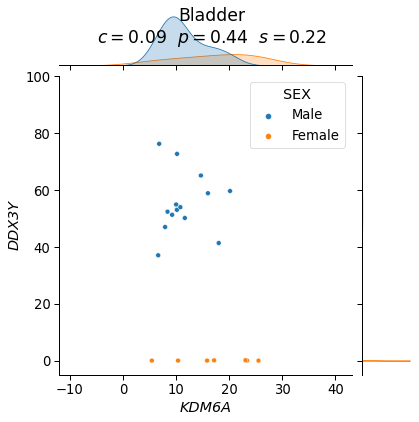

In [43]:
_tissue_data = plot_gene_pair(
    "bladder",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_heart_atrial_appendage-KDM6A_vs_DDX3Y.svg')

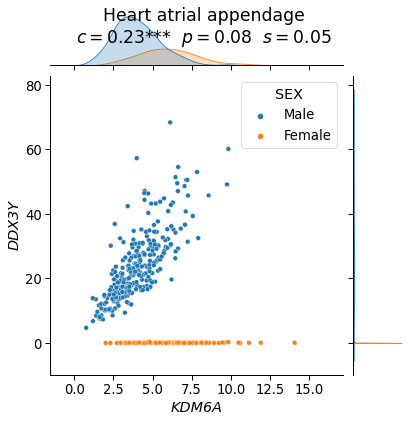

In [44]:
_tissue_data = plot_gene_pair(
    "heart_atrial_appendage",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Spearman low, CCC high

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_heart_left_ventricle-KDM6A_vs_DDX3Y.svg')

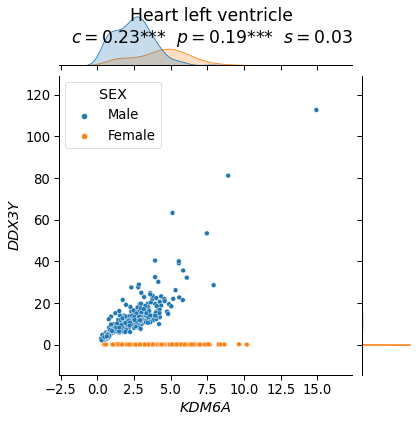

In [45]:
_tissue_data = plot_gene_pair(
    "heart_left_ventricle",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_adipose_visceral_omentum-KDM6A_vs_DDX3Y.svg')

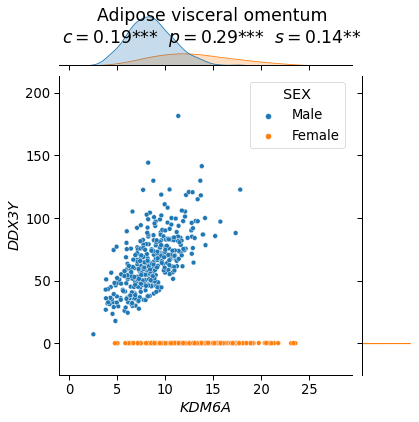

In [46]:
_tissue_data = plot_gene_pair(
    "adipose_visceral_omentum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_skin_not_sun_exposed_suprapubic-KDM6A_vs_DDX3Y.svg')

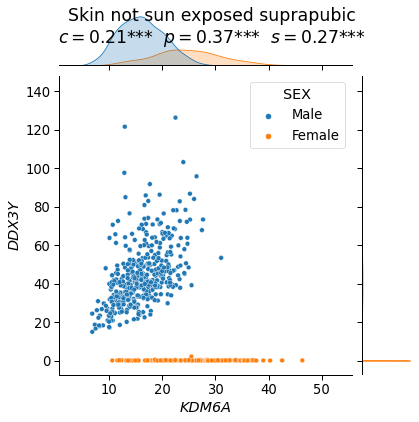

In [47]:
_tissue_data = plot_gene_pair(
    "skin_not_sun_exposed_suprapubic",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'DDX3Y')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_ddx3y/gtex_pancreas-KDM6A_vs_DDX3Y.svg')

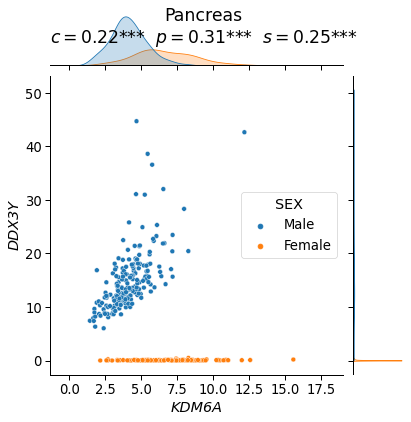

In [48]:
_tissue_data = plot_gene_pair(
    "pancreas",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

# Create final figure

In [49]:
from svgutils.compose import Figure, SVG, Panel

In [50]:
name_suffix = f"{gene0_symbol}_vs_{gene1_symbol}"
display(name_suffix)

'KDM6A_vs_DDX3Y'

In [51]:
Figure(
    "6.0767480cm",
    "8.7045984cm",
    Panel(
        SVG(OUTPUT_FIGURE_DIR / f"gtex_whole_blood-{name_suffix}.svg").scale(0.005),
        SVG(OUTPUT_FIGURE_DIR / f"gtex_testis-{name_suffix}.svg")
        .scale(0.005)
        .move(2, 0),
        SVG(OUTPUT_FIGURE_DIR / f"gtex_cells_cultured_fibroblasts-{name_suffix}.svg")
        .scale(0.005)
        .move(2 * 2, 0),
    ),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / f"gtex_brain_cerebellum-{name_suffix}.svg").scale(
            0.005
        ),
        SVG(
            OUTPUT_FIGURE_DIR / f"gtex_small_intestine_terminal_ileum-{name_suffix}.svg"
        )
        .scale(0.005)
        .move(2, 0),
        SVG(OUTPUT_FIGURE_DIR / f"gtex_breast_mammary_tissue-{name_suffix}.svg")
        .scale(0.005)
        .move(2 * 2, 0),
    ).move(0, 2.2),
    Panel(
        SVG(
            OUTPUT_FIGURE_DIR
            / f"gtex_brain_anterior_cingulate_cortex_ba24-{name_suffix}.svg"
        ).scale(0.005),
        SVG(OUTPUT_FIGURE_DIR / f"gtex_brain_amygdala-{name_suffix}.svg")
        .scale(0.005)
        .move(2, 0),
        SVG(OUTPUT_FIGURE_DIR / f"gtex_heart_atrial_appendage-{name_suffix}.svg")
        .scale(0.005)
        .move(2 * 2, 0),
    ).move(0, 2.2 * 2),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / f"gtex_vagina-{name_suffix}.svg").scale(0.005),
        SVG(OUTPUT_FIGURE_DIR / f"gtex_ovary-{name_suffix}.svg")
        .scale(0.005)
        .move(2, 0),
        SVG(OUTPUT_FIGURE_DIR / f"gtex_uterus-{name_suffix}.svg")
        .scale(0.005)
        .move(2 * 2, 0),
    ).move(0, 2.2 * 3),
).save(OUTPUT_FIGURE_DIR / f"gtex-{name_suffix}-main.svg")

Now open the file, reside to fit drawing to page, and add a white rectangle to the background.